Lesson 8: Overfitting and underfitting, label probability and calibration, AUC scores

We begin with a simple example where we can clearly see when the model overfits/underfits the data

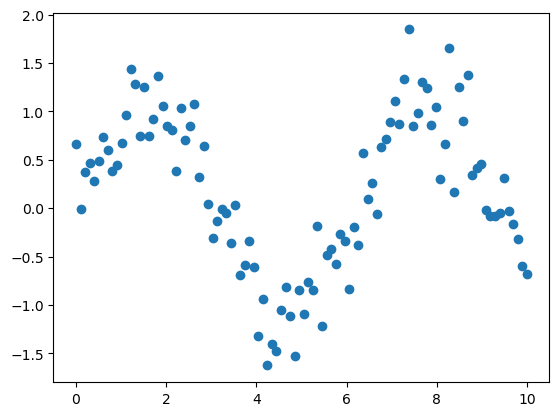

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Generate some data
X = np.linspace(0, 10, 100)
y = np.sin(X) + np.random.normal(scale=0.3, size=len(X))

plt.scatter(X, y)





Choose a model to fit the data. We need to fit the values of a numerical array, hence it's a regression problem. We need a parametric model to demonstrate how the choice of parameters can affect model performance with respect to overfitting/underfitting. To keep it simple, we go with polynomial regression

A longer way of implementing polynomial regression 

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# we don't include bias, because we will fit linear regression to transformed features 
poly = PolynomialFeatures(degree=3, include_bias=False)

# NOW - transform the features 
x_poly = poly.fit_transform(X.reshape(-1, 1))

###### fit regression model to the transformed features 
poly_reg = LinearRegression()
poly_reg.fit(x_poly, y)

# predict
y_pred = poly_reg.predict(x_poly)



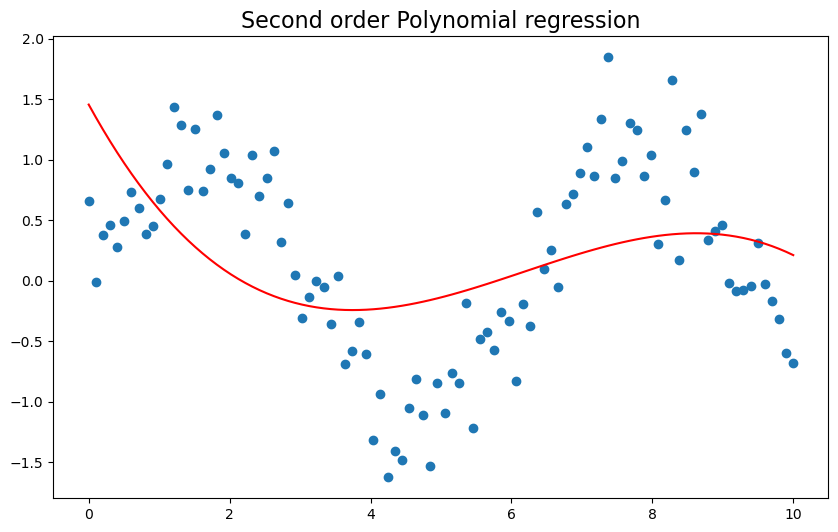

In [3]:
plt.figure(figsize=(10, 6))
plt.title("Second order Polynomial regression", size=16)
plt.scatter(X, y)
plt.plot(X, y_pred, c="red")
plt.show()

A faster way: use Pipeline! The algorithm is entirely the same but can be done in one step!

In [4]:
# Reshape features (into a 2-dimensional matrix) directly from the start 
X = np.linspace(0, 10, 100).reshape(-1, 1)
# rvael() for flattening the array
y = np.sin(X).ravel() + np.random.normal(scale=0.3, size=X.shape[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Do the following: define a set of different degree we want to try:


In [5]:
all_degree = [2, 4, 18]

Create a method for plotting the scores

In [6]:
# Function to plot model predictions
def plot_model(model, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train, y_train, color="blue", label="Training data")
    plt.scatter(X_test, y_test, color="red", label="Testing data")

    # Plot the model predictions
    X_range = np.linspace(0, 10, 500).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plt.plot(X_range, y_pred, color="green", label="Model prediction")

    plt.title(title)
    plt.legend()
    plt.show()

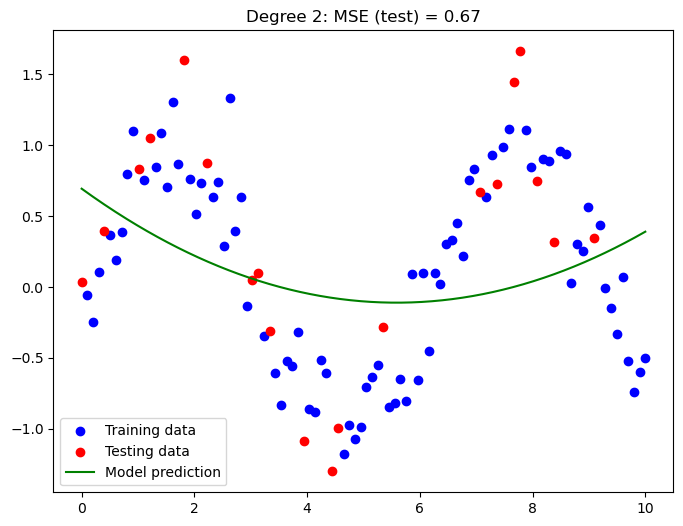

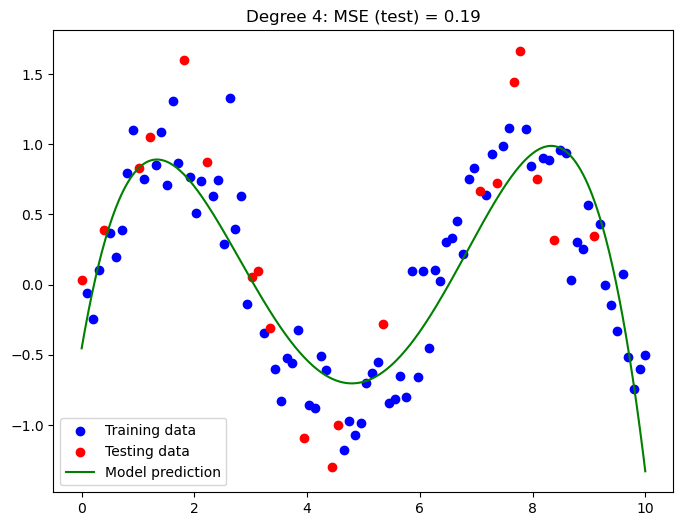

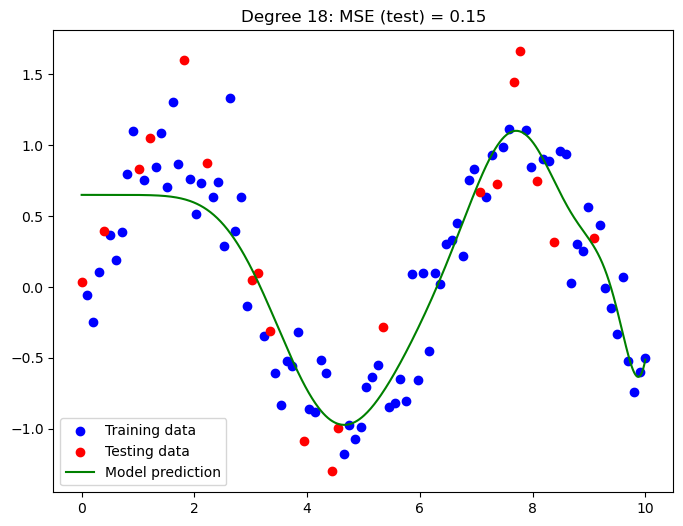

In [7]:
# Train and evaluate models with different polynomial degrees
for degree in all_degree:
    # check this: Pipeline maps the 2 functions together!
    model =  make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # predict! 
    y_pred = model.predict(X_test)
    # Calculate MSE
    test_error = mean_squared_error(y_test, y_pred)
    
    # plot the results
    title = (
    f"Degree {degree}: MSE (test) = {test_error:.2f}"
    )
    plot_model(model, title)



How to know is model if overfitted? Compare accuracy of performance on the training and testing sets!

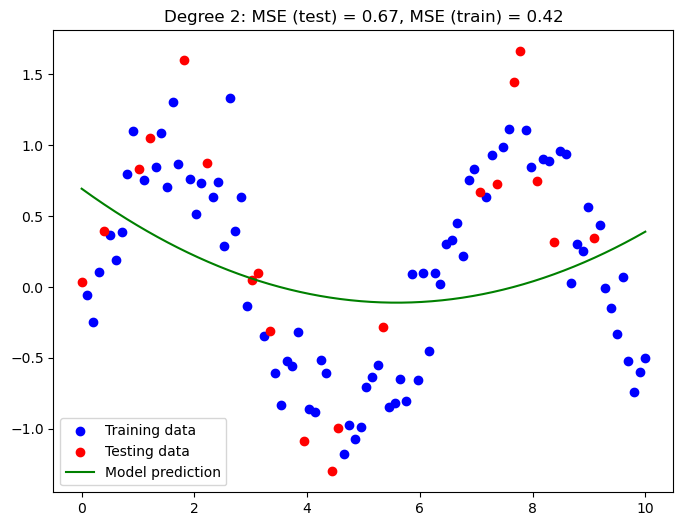

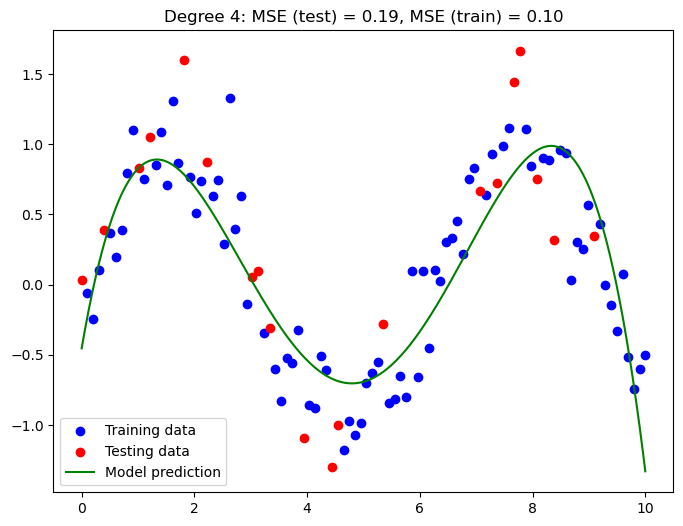

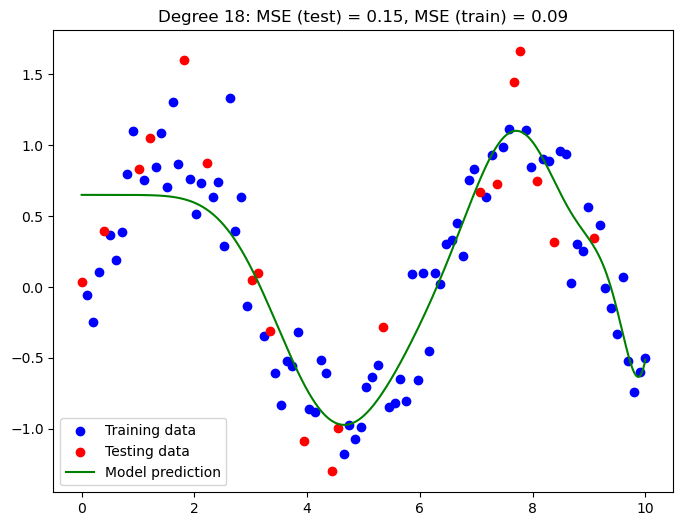

In [8]:
# Train and evaluate models with different polynomial degrees
for degree in all_degree:
    model =  make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # Calculate MSE - now also compute the MSE on the training set
    train_error = mean_squared_error(y_train, model.predict(X_train))
    test_error = mean_squared_error(y_test, model.predict(X_test))
    
    # plot the results
    title = (
    f"Degree {degree}: MSE (test) = {test_error:.2f}, MSE (train) = {train_error:.2f}"
    )
    plot_model(model, title)



Let's shift to a binary classification problem and estimate the label probabilities

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
# choose some binary classifier (for example, support vector machine)
from sklearn.svm import SVC

# Generate some binary classification data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the data like we normally do, but this time for a calibration dataset
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.3, random_state=42)



Estimate raw probabilities. Note: in SVM, you can use a decision function to obtain estimates of the probabilities. Just need to scale the values so that they are in a range of [0, 1] 

In [10]:
# Take SVM (linear kernel by default)
clf = SVC(probability=False)
clf.fit(X_train, y_train)

raw_scores = clf.decision_function(X_cal)
raw_scores


array([ 2.58894818e-01,  2.38433115e-01, -3.59555894e-01,  8.09822330e-01,
        1.24627526e+00, -7.48013325e-01, -6.70599403e-01,  6.96076452e-01,
        6.08821197e-01, -2.01545976e-01,  1.59283340e+00,  1.72779911e-01,
       -1.66975761e+00,  2.70602872e-01,  5.50923461e-01, -9.01704750e-01,
       -7.82884191e-01,  1.26799957e+00,  1.10981765e+00, -8.51947608e-02,
        1.04252965e+00, -6.32611772e-01, -8.80466107e-01, -9.43297876e-01,
        1.58995955e+00, -1.54061899e+00,  1.17252978e+00,  1.33767054e+00,
       -1.20878523e+00,  1.51910465e+00,  3.08540040e-01,  1.45200395e+00,
        4.73163194e-01, -1.26198924e+00, -2.87914630e-01, -4.03606347e-01,
       -1.87406235e+00,  5.97967746e-03, -1.24972737e+00, -6.07299546e-01,
       -1.87919486e+00,  1.75652891e+00, -1.25968223e+00, -5.02954711e-01,
        1.04408561e-01, -1.98012112e+00,  1.93965814e+00, -1.69145733e+00,
        8.18592578e-01,  2.32524581e+00, -1.69179684e+00, -6.54611415e-01,
       -1.16104602e+00,  

What do these values show? SVM finds a hyperplane that splits the space, and the decision function returns the distance between a point in space, which corresponds to each feature, and this hyperplane. 

 let's plot the decision values

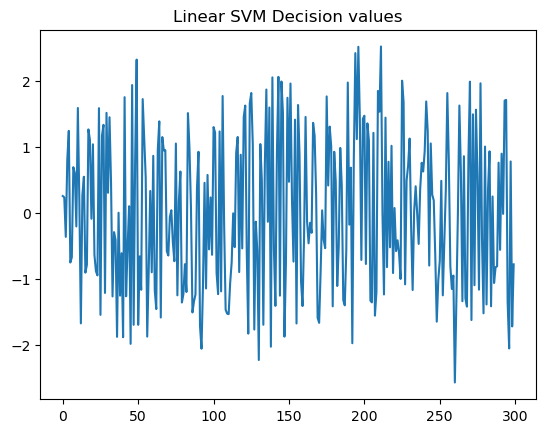

In [11]:
#xx = np.linspace(-3, 3, len(raw_scores))
plt.plot(raw_scores)
plt.title('Linear SVM Decision values')
plt.show()

The obtained values from the decision function can be scaled and used as probability estimates. However, we are not sure if those estimates are rigorous. Hence, we perform additional calibration of the probabilities. We then compare the calibrated and uncalibrated probabilties

One way of calibrating probabilities is to use a Platt-scaling method! We will implement it manually

In [12]:
# Split data into training, calibration, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=10)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

# Get raw decision function scores
raw_scores = clf.decision_function(X_cal)

# Fit logistic regression for Platt scaling
platt_scaler = LogisticRegression()

raw_scores = raw_scores.reshape(-1, 1)  # Reshape for LogisticRegression
platt_scaler.fit(raw_scores, y_cal)


# Calibrated probabilities
calibrated_probs = platt_scaler.predict_proba(raw_scores)[:, 1]



What Platt-scaler does: Transforms the raw scores from desicsion function into calibrated probabilities.
P(y = 1 | x) = 1/(1 + e^{-(ax + b)}), where a and b are learned from the logistic regression!

Compare uncalibrated and calibrated probabilities

Check if the raw estimates are actually within the required range:

In [13]:
all(0 <= i <= 1  for i in raw_scores) 

False

Note: values are outside the probability range! Scale them so that they are within the range (0, 1)

In [14]:
uncalibrated_probs = clf.decision_function(X_cal)

# can scale like this
uncalibrated_probs = (uncalibrated_probs - uncalibrated_probs.min()) / \
                   (uncalibrated_probs.max() - uncalibrated_probs.min())
                   


In [15]:
# or like this
uncalibrated_probs = clf.decision_function(X_cal)

uncalibrated_probs = [(i -  raw_scores.min())/(raw_scores.max() - raw_scores.min()) for i in uncalibrated_probs]

In [16]:
# check again!!
all(0 <= i <= 1 for i in uncalibrated_probs) 

True

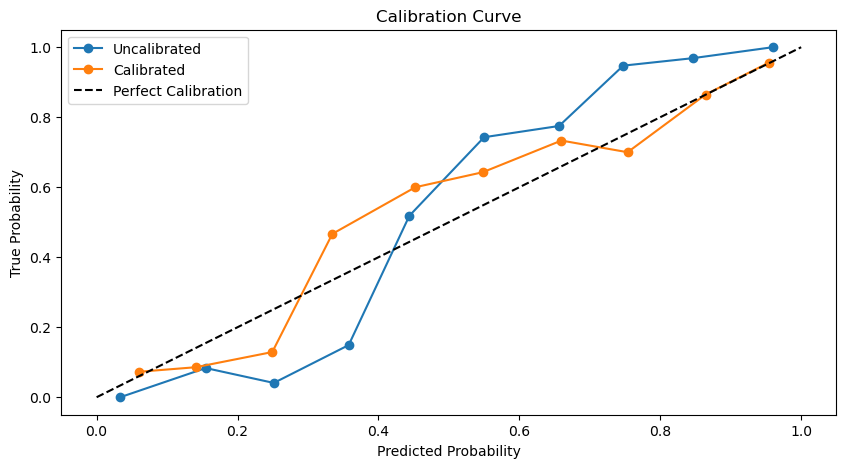

In [17]:
# 
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt


# Calibration plots
plt.figure(figsize=(10, 5))
for probs, label in zip([uncalibrated_probs, calibrated_probs], ["Uncalibrated", "Calibrated"]):
    prob_true, prob_pred = calibration_curve(y_cal, probs, n_bins=10, strategy="uniform")
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

Now let's look at predict_proba method that SVC (and some other classifiers possess)

In [18]:
# Note: for this to work, it is essential we specify that we want probabilities too!
clf = SVC(probability=True)
clf.fit(X_train, y_train)

# Use the predict_proba 
y_pred = clf.predict_proba(X_cal)
y_pred

array([[1.68040315e-01, 8.31959685e-01],
       [7.31594412e-02, 9.26840559e-01],
       [1.86866928e-01, 8.13133072e-01],
       [7.31953258e-02, 9.26804674e-01],
       [4.82195834e-02, 9.51780417e-01],
       [9.14691442e-01, 8.53085581e-02],
       [8.83061277e-01, 1.16938723e-01],
       [1.77917465e-01, 8.22082535e-01],
       [1.72848951e-01, 8.27151049e-01],
       [5.37390369e-01, 4.62609631e-01],
       [1.50533118e-02, 9.84946688e-01],
       [2.43117058e-01, 7.56882942e-01],
       [9.52840889e-01, 4.71591107e-02],
       [7.79772881e-02, 9.22022712e-01],
       [5.00000000e-01, 5.00000000e-01],
       [9.14682627e-01, 8.53173726e-02],
       [8.78328478e-01, 1.21671522e-01],
       [3.89912868e-02, 9.61008713e-01],
       [6.94427177e-02, 9.30557282e-01],
       [6.92342511e-01, 3.07657489e-01],
       [2.59587628e-02, 9.74041237e-01],
       [8.22936731e-01, 1.77063269e-01],
       [9.55723176e-01, 4.42768237e-02],
       [9.14592942e-01, 8.54070582e-02],
       [3.625601

As a return, we get an 2-D array. Each row corresponds to a vector of probabilities that this observation belongs to class 0 and 1, respectievly, so P(Y = 0) and P(Y = 1). Interesting fact that the SVC from sklearn actually does use some type of calibration, and predcit_proba returns already calibrated probabilities (at least according to the documentation from developers)

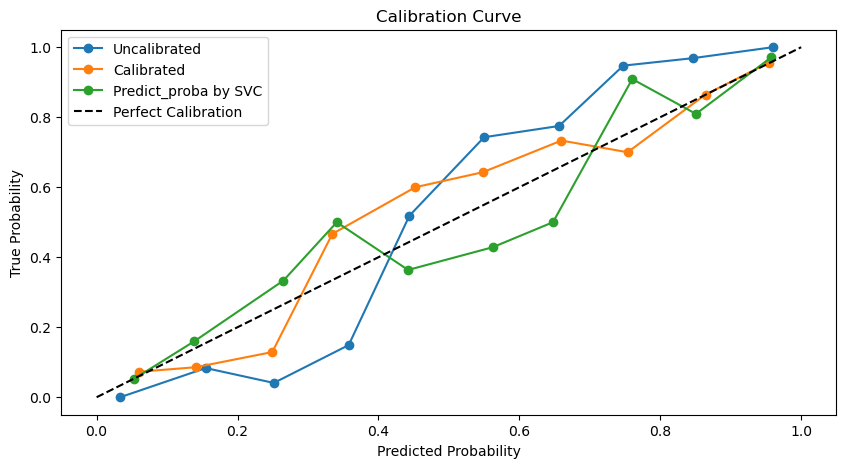

In [19]:
# Calibration plots
plt.figure(figsize=(10, 5))
for probs, label in zip([uncalibrated_probs, calibrated_probs], ["Uncalibrated", "Calibrated"]):
    prob_true, prob_pred = calibration_curve(y_cal, probs, n_bins=10, strategy="uniform")
    plt.plot(prob_pred, prob_true, marker='o', label=label)
# plot the probabilities obtained from predict_proba
y_pred = clf.predict_proba(X_cal)[:, 1]
prob_true, prob_pred = calibration_curve(y_cal, y_pred, n_bins=10, strategy="uniform")
plt.plot(prob_pred, prob_true, marker='o', label= 'Predict_proba by SVC')
# plot settings 
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

Note: Calibration is good when you need to work directly with probabilities. Sometimes, when you use probabilities to compute some other matrics, calibration might not make any difference! Let's take a look at the example with the AUCs

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
#import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svc = SVC(probability=True, random_state=42)  # Enable probability estimates
svc.fit(X_train, y_train)

# Predict probabilities for the positive class
y_probs = svc.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Compute AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.2f}")



AUC Score: 0.91


What is the AUC? 
First, define the ROC-curve:

 1) TPR = TP/(TP + FN)
 
    FPR = FP/(FP + TN)

 2) Vary the decision boundary theta from 0 to 1 and compute the outcome probability (for positives) for every theta:
 
Actual class: 0,
Prediction probability: 0.75

theta = 0.6.
An observation is classified as 1, because P(Y = 1) = 0.75 > 0.6

theta = 0.7.
An observation is classified as 1, because P(Y = 1) = 0.75 > 0.7

theta = 0.8.
An observation is classified as 0, because P(Y = 1) = 0.75 < 0.8

3) Compute TPR and FPR for each value of theta - this is the ROC curve

4) AUC is the area under this curve

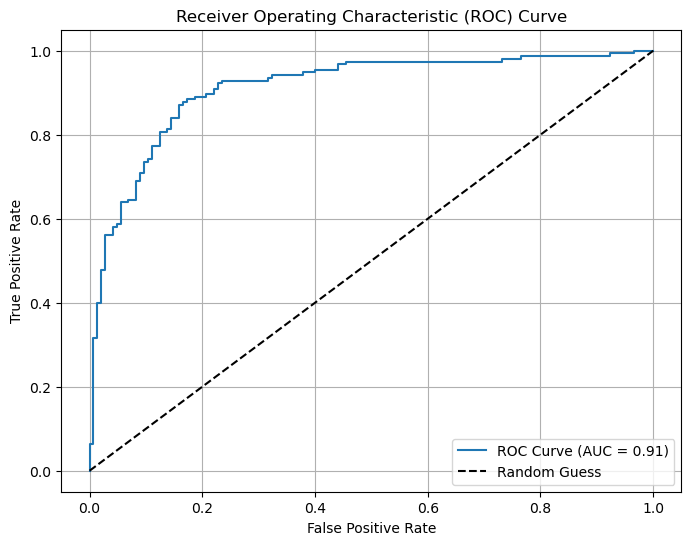

In [21]:
# Step 6: Plot the ROC Curve
fpr, tpr, tr = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Let's demonstrate that we actually do not need the calibration for AUC scores

In [22]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=2000, n_features=20, random_state=10)

# Split data into training, calibration, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=10)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=15)

# Train a logistic regression model
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(X_train, y_train)

# Calibrate the model using Platt scaling (sigmoid method)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_calib, y_calib)

# Make predictions and evaluate performance
probs_uncalibrated = clf.predict_proba(X_test)[:, 1]
probs_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]



We got calibrated and uncalibrated probabilities! Now let's plot the ROC curve for each of them

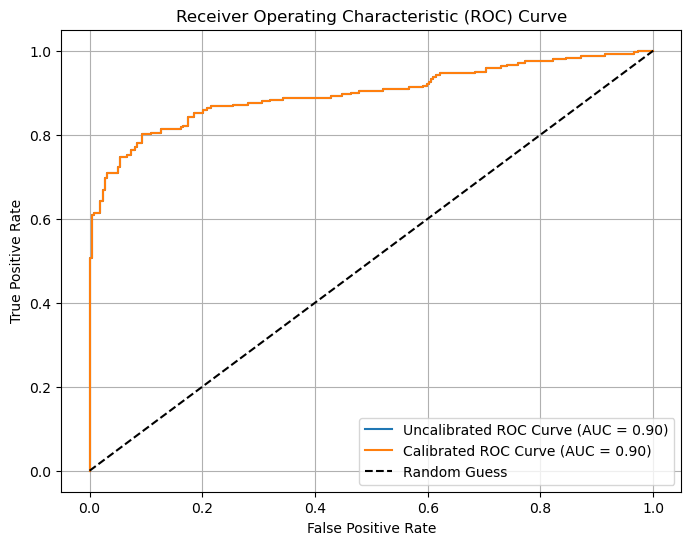

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr_un, tpr_un, tr_un = roc_curve(y_test, probs_uncalibrated)

fpr, tpr, tr = roc_curve(y_test, probs_calibrated)

auc_score_un = roc_auc_score(y_test, probs_uncalibrated)

auc_score = roc_auc_score(y_test, probs_calibrated)

plt.figure(figsize=(8, 6))
plt.plot(fpr_un, tpr_un, label=f"Uncalibrated ROC Curve (AUC = {auc_score_un:.2f})")
plt.plot(fpr, tpr, label=f"Calibrated ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Grid search, cross validation and scaling

In [24]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=10)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the pipeline with scaling and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()), # can also try minmax scaler
    ('svm', SVC(kernel='rbf'))
])

# Define parameter grid for GridSearch
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

# Perform GridSearch with cross-validation
# cv states for k in cross =-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
# now grid_search is of type model. You can fit it to the data and predict!
grid_search.fit(X_train, y_train)

# Display the best parameters and their corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Best parameters found: {'svm__C': 1, 'svm__gamma': 0.1}
Best cross-validation accuracy: 0.9128571428571428

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.88      0.92       138
           1       0.91      0.96      0.93       162

    accuracy                           0.93       300
   macro avg       0.93      0.92      0.93       300
weighted avg       0.93      0.93      0.93       300

